In [ ]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

In [ ]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/Research')

Drive already mounted at /Research; to attempt to forcibly remount, call drive.mount("/Research", force_remount=True).


In [ ]:
pip install pydub

In [ ]:
pip install python_speech_features

In [ ]:
pip install audiomentations

In [ ]:
import pandas as pd       
import os 
import math 
import numpy as np
import matplotlib.pyplot as plt  
import IPython.display as ipd
import librosa as lr
import librosa.display
from glob import glob
from tqdm import tqdm
import scipy.io
from os.path import dirname, join as pjoin
from scipy.io import wavfile
from pydub import AudioSegment
from python_speech_features import mfcc, logfbank
from sklearn.model_selection import train_test_split
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from keras.layers import Dropout, TimeDistributed
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.preprocessing import image
from keras.models import Sequential
from keras.utils import plot_model
from keras.models import load_model
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import keras
from keras import layers
from keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten, Activation
from keras.layers import BatchNormalization
from keras import applications
from keras.callbacks import ReduceLROnPlateau
import pickle
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import  average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print(os.listdir("/Research/My Drive/Research"))

['reading-passage.txt', 'speakers_all.csv', 'recordings', 'wavrecordings', '.ipynb_checkpoints', 'vid_len_df.csv', 'top_lang_df.csv', 'new_df.csv', 'pickles', 'Models', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5']


In [ ]:
df = pd.read_csv("/Research/My Drive/Research/speakers_all.csv", header=0)

In [ ]:
df.head()

age  age_onset              birthplace  ... Unnamed: 9 Unnamed: 10 Unnamed: 11
0  24.0       12.0         koussi, senegal  ...        NaN         NaN         NaN
1  18.0       10.0          buea, cameroon  ...        NaN         NaN         NaN
2  48.0        8.0  hong, adamawa, nigeria  ...        NaN         NaN         NaN
3  42.0       42.0   port-au-prince, haiti  ...        NaN         NaN         NaN
4  40.0       35.0   port-au-prince, haiti  ...        NaN         NaN         NaN

[5 rows x 12 columns]

In [ ]:
df.drop(df.columns[9:12],axis = 1, inplace = True)
df.head()

age  age_onset              birthplace  ... speakerid   country file_missing?
0  24.0       12.0         koussi, senegal  ...       788   senegal          True
1  18.0       10.0          buea, cameroon  ...      1953  cameroon          True
2  48.0        8.0  hong, adamawa, nigeria  ...      1037   nigeria          True
3  42.0       42.0   port-au-prince, haiti  ...      1165     haiti          True
4  40.0       35.0   port-au-prince, haiti  ...      1166     haiti          True

[5 rows x 9 columns]

In [ ]:
df['file_missing?'].value_counts()

False    2140
True       32
Name: file_missing?, dtype: int64

In [ ]:
df.shape

(2172, 9)

In [ ]:
df.drop(df[df['file_missing?'] == True].index, inplace = True)

In [ ]:
df.head()

age  age_onset  ...       country file_missing?
32  27.0        9.0  ...  south africa         False
33  40.0        5.0  ...  south africa         False
34  43.0        4.0  ...  south africa         False
35  26.0        8.0  ...  south africa         False
36  19.0        6.0  ...  south africa         False

[5 rows x 9 columns]

In [ ]:
audio = glob('/Research/My Drive/Research/recordings/recordings/*')

In [ ]:
len(audio)

2138

In [ ]:
src_folder = '/Research/My Drive/Research/recordings/recordings'

In [ ]:
src_files = glob('/Research/My Drive/Research/recordings/recordings/*.mp3'.format(fp=src_folder))

In [ ]:
src_files[0]

'/Research/My Drive/Research/recordings/recordings/hebrew9.mp3'

In [ ]:
len(src_files)

2138

In [ ]:
src_files[0].split('/')

['',
 'Research',
 'My Drive',
 'Research',
 'recordings',
 'recordings',
 'hebrew9.mp3']

In [ ]:
src_files_nm = [x.split('/')[-1].split('.')[0] for x in src_files]

In [ ]:
len(src_files_nm)

2138

In [ ]:
fnames_csv = [x.strip().lower() for x in list(df.filename)]

In [ ]:
len(fnames_csv)

2140

In [ ]:
fnames_csv[0]

'afrikaans1'

In [ ]:
src_files_nm[0]

'hebrew9'

Checking the record present in CSV but dont have corresponding audio

In [ ]:
# Filename present in CSV but actual files not found
nf_act_files = []
for x in fnames_csv:
    if x not in src_files_nm:
        nf_act_files.append(x)

# Files present in the folder but records not found in provided CSV
nf_file_record = []
for x in src_files_nm:
    if x not in fnames_csv:
        nf_file_record.append(x)

In [ ]:
len(nf_act_files), len(nf_file_record)

(2, 0)

In [ ]:
df['filename'].isnull().sum()

0

In [ ]:
test_df = df

In [ ]:
for x in nf_act_files:
  test_df = test_df[test_df['filename'] != x]

In [ ]:
df.shape, test_df.shape

((2140, 9), (2138, 9))

Studying features of audio

In [ ]:
ipd.Audio(audio[0])

In [ ]:
ipd.Audio(audio[3])

In [ ]:
FIG_SIZE = (15,10)
audio1 = audio[0]
audio2 = audio[3]

In [ ]:
signal, sample_rate = librosa.load(audio1, sr=22050)
signal_f, sample_rate = librosa.load(audio2, sr=22050)

Text(0.5, 1.0, 'Waveform for male voice')

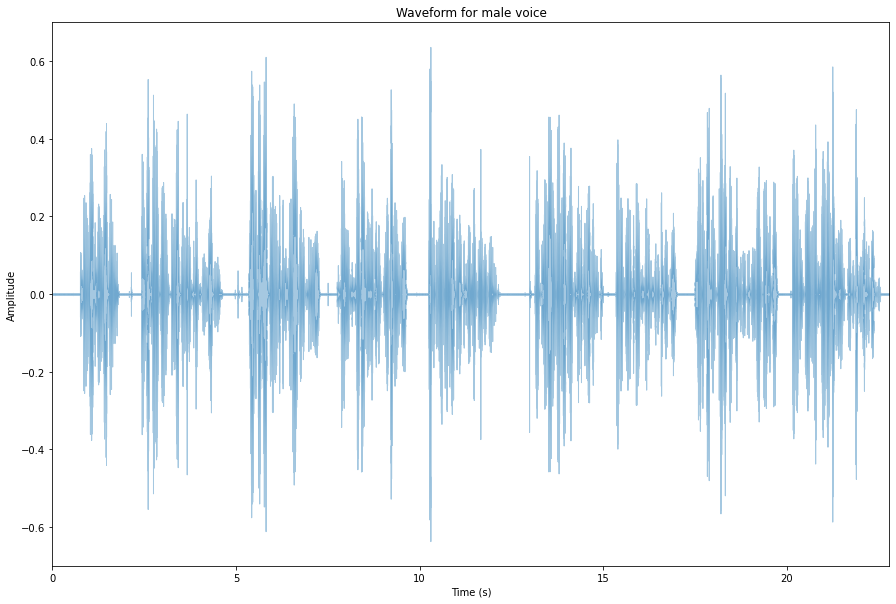

In [ ]:
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(signal, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform for male voice")

Text(0.5, 1.0, 'Waveform for female voice')

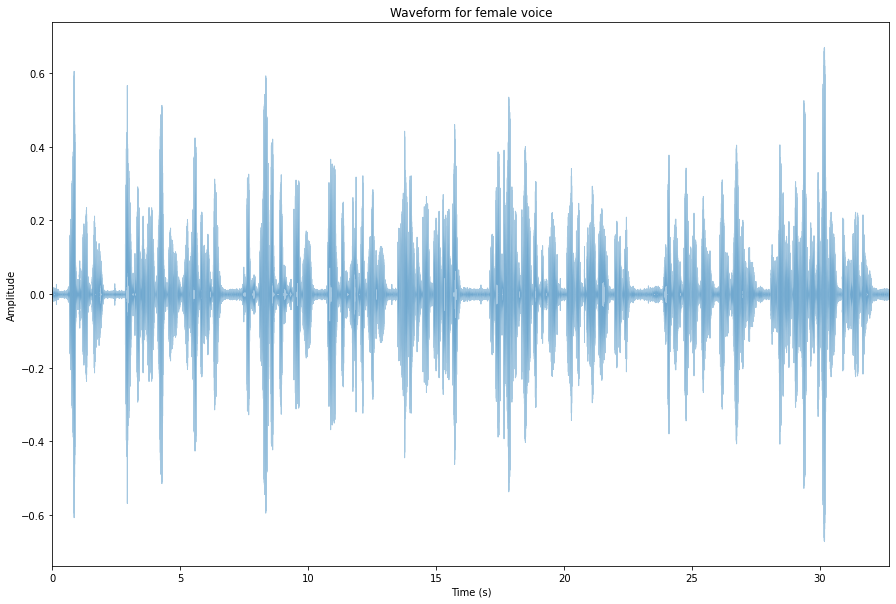

In [ ]:
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(signal_f, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform for female voice")

In [ ]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sample_rate, len(magnitude))

In [ ]:
fft_female = np.fft.fft(signal_f)
magnitude_female = np.abs(fft_female)
frequency_female = np.linspace(0, sample_rate, len(magnitude_female))

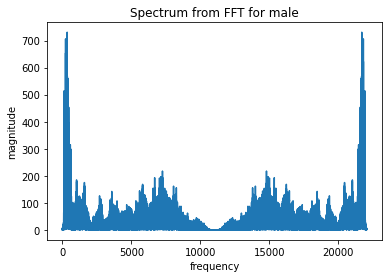

In [ ]:
plt.plot(frequency, magnitude)
plt.xlabel("frequency")
plt.ylabel("magnitude")
plt.title("Spectrum from FFT for male")
plt.show()

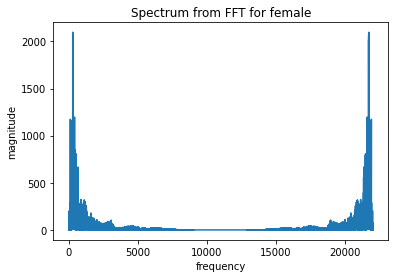

In [ ]:
plt.plot(frequency_female, magnitude_female)
plt.xlabel("frequency")
plt.ylabel("magnitude")
plt.title("Spectrum from FFT for female")
plt.show()

Since we can see that Frequency and Magnitude plot is symmetrical from center so we will just use the half of the plot.

In [ ]:
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_frequency = frequency[:int(len(magnitude)/2)]

In [ ]:
left_spectrum_female = magnitude_female[:int(len(magnitude_female)/2)]
left_frequency_female = frequency_female[:int(len(magnitude_female)/2)]

Text(0.5, 1.0, 'Power spectrum for male')

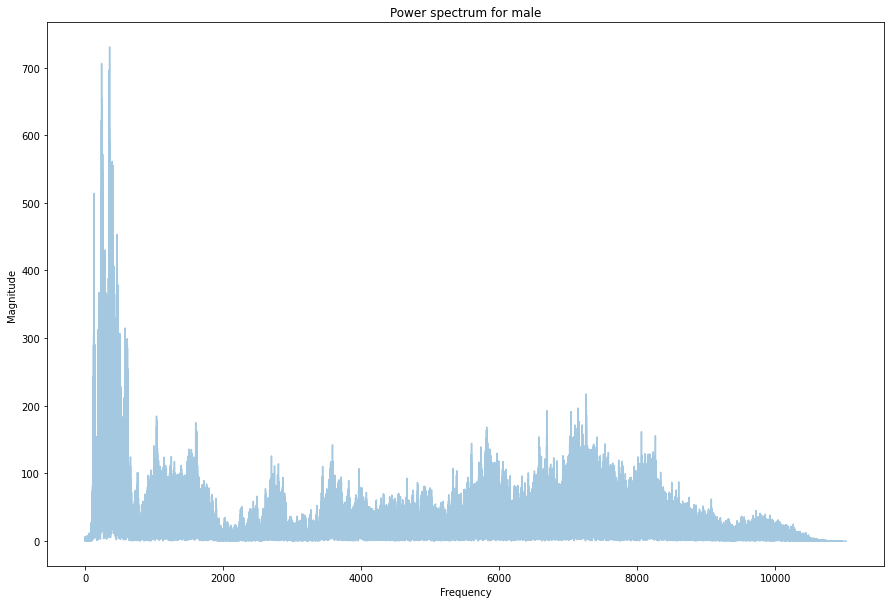

In [ ]:
plt.figure(figsize=FIG_SIZE)
plt.plot(left_frequency, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum for male")

Text(0.5, 1.0, 'Power spectrum for female')

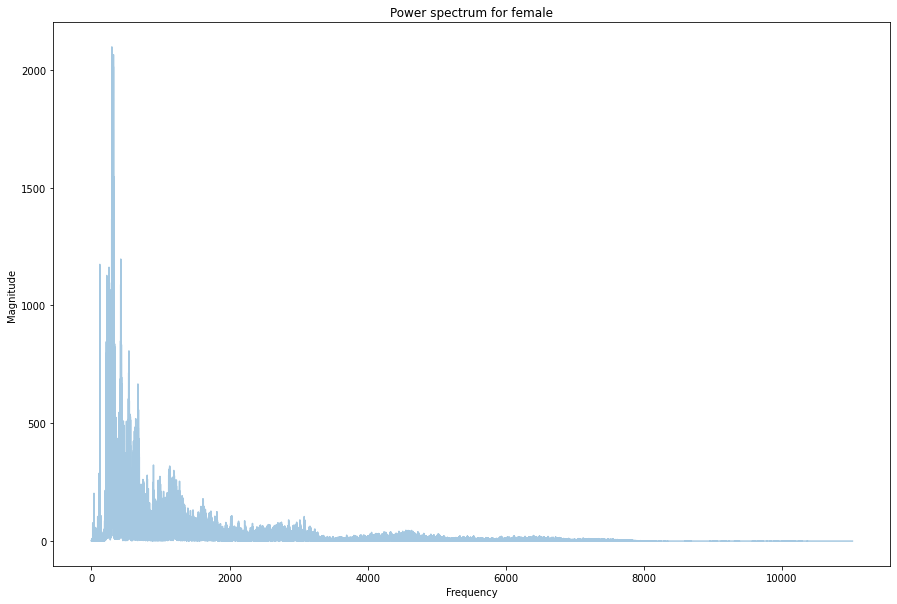

In [ ]:
plt.figure(figsize=FIG_SIZE)
plt.plot(left_frequency_female, left_spectrum_female, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum for female")

In [ ]:
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate
print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


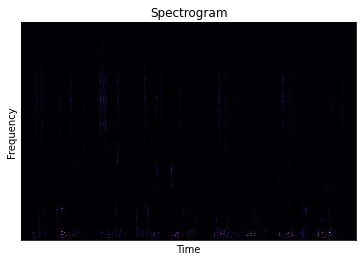

In [ ]:
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)
librosa.display.specshow(spectrogram)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Spectrogram")
plt.colorbar
plt.show()

Not much is clear from this figure so we will take it on a log scale

Text(0.5, 1.0, 'Spectrogram (dB)')

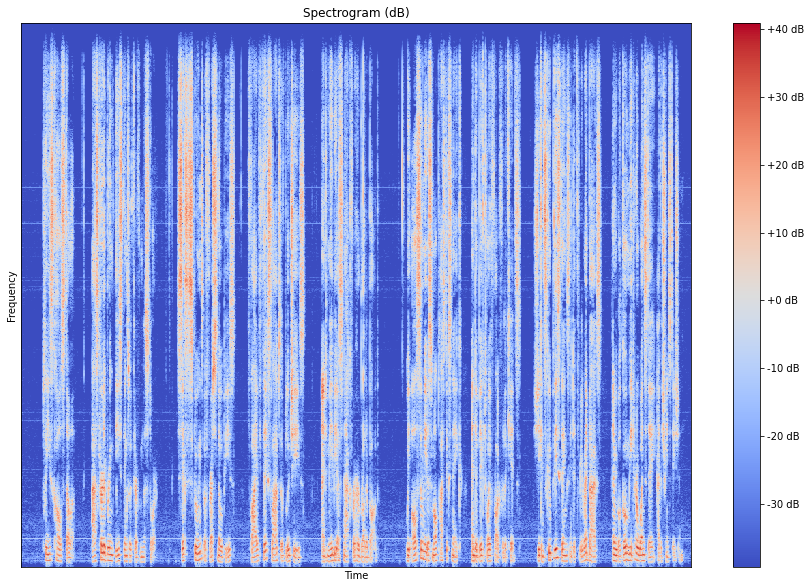

In [ ]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

Text(0.5, 1.0, 'Spectrogram (dB) for females')

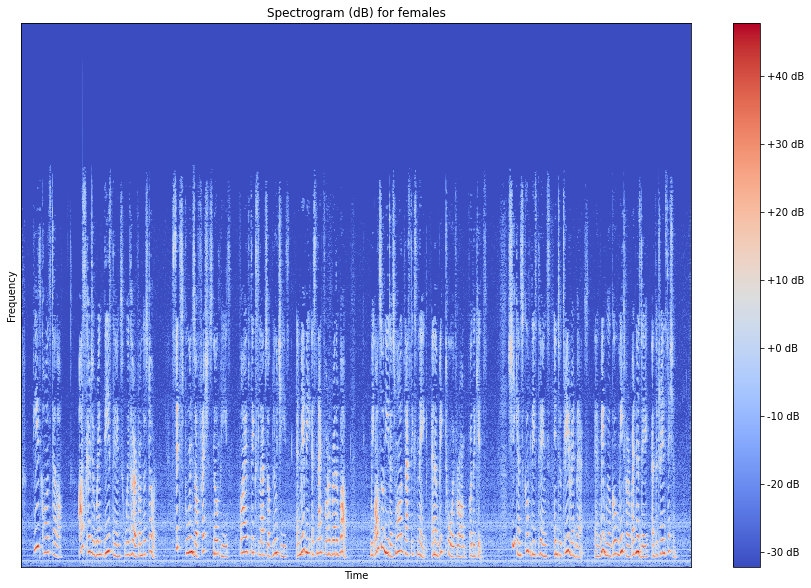

In [ ]:
stft_female = librosa.stft(signal_f, n_fft=n_fft, hop_length=hop_length)
spectrogram_female = np.abs(stft_female)
log_spectrogram_female = librosa.amplitude_to_db(spectrogram_female)
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram_female, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB) for females")

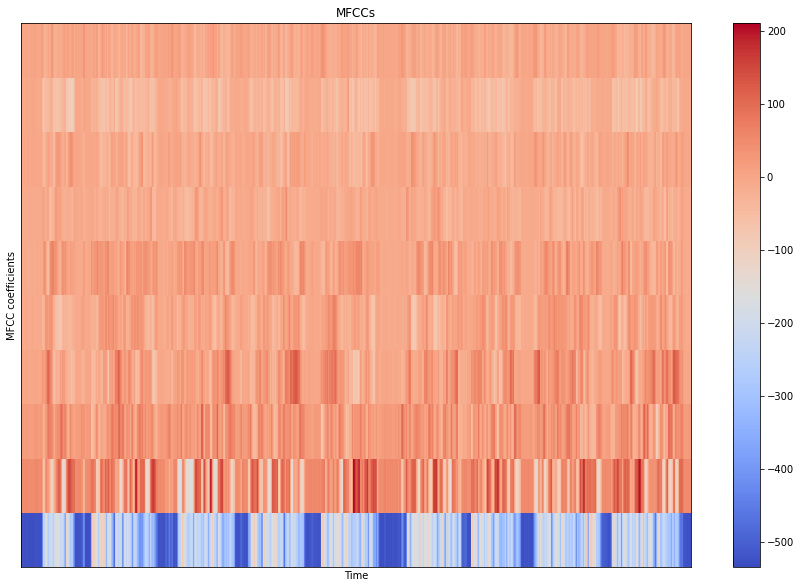

In [ ]:
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=10)
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")
plt.show()

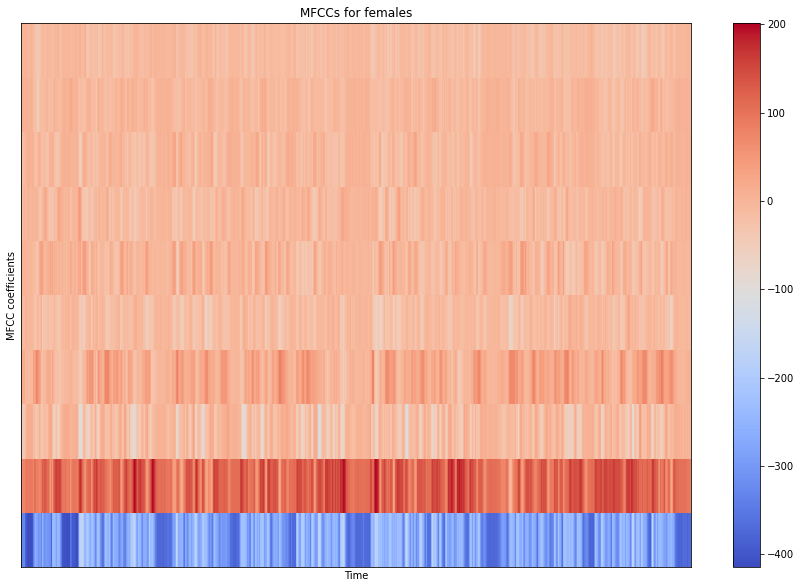

In [ ]:
MFCCs_females = librosa.feature.mfcc(signal_f, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=10)
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs_females, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs for females")
plt.show()

In [ ]:
df.head()

age  age_onset  ...       country file_missing?
32  27.0        9.0  ...  south africa         False
33  40.0        5.0  ...  south africa         False
34  43.0        4.0  ...  south africa         False
35  26.0        8.0  ...  south africa         False
36  19.0        6.0  ...  south africa         False

[5 rows x 9 columns]

Exploratory data analysis

In [ ]:
df.groupby("native_language")['age'].describe().sort_values(by=['count'],ascending=False)

count       mean        std   min    25%   50%   75%   max
native_language                                                            
english          579.0  34.482729  16.734510   6.0  21.00  29.0  44.0  90.0
spanish          162.0  34.129630  13.972528  17.0  23.00  30.0  45.0  80.0
arabic           102.0  30.950980  12.047248  18.0  21.25  28.0  38.0  70.0
mandarin          65.0  30.015385   8.193924  18.0  24.00  28.0  34.0  53.0
french            63.0  33.333333  16.246091  18.0  21.00  27.0  39.0  78.0
...                ...        ...        ...   ...    ...   ...   ...   ...
konkani            1.0  38.000000        NaN  38.0  38.00  38.0  38.0  38.0
kirghiz            1.0  32.000000        NaN  32.0  32.00  32.0  32.0  32.0
kanuri             1.0  48.000000        NaN  48.0  48.00  48.0  48.0  48.0
kannada            1.0  26.000000        NaN  26.0  26.00  26.0  26.0  26.0
zulu               1.0  24.000000        NaN  24.0  24.00  24.0  24.0  24.0

[202 rows x 8 columns]

In [ ]:
df.groupby("age")['sex'].describe().sort_values(by=['count'],ascending=False)

count unique     top freq
age                           
20.0   131      2    male   72
21.0   125      2    male   63
19.0   123      2    male   64
18.0   105      2    male   61
22.0   104      2    male   59
...    ...    ...     ...  ...
27.5     1      1    male    1
88.0     1      1  female    1
89.0     1      1  female    1
90.0     1      1    male    1
97.0     1      1    male    1

[80 rows x 4 columns]

In [ ]:
df.groupby('sex')['country'].describe().sort_values(by=['count'],ascending=False)

count unique     top freq
sex                             
male    1101    151     usa  198
female  1033    145     usa  193
famale     1      1  taiwan    1

In [ ]:
dst_folder = '/Research/My Drive/Research/wav recordings'

In [ ]:
 #for el in src_files:
     #AudioSegment.from_mp3(el).export(el.replace(src_folder, dst_folder).replace('.mp3', '.wav'), format='wav')

In [ ]:
len(dst_folder)

42

In [ ]:
df.head()

age  age_onset  ...       country file_missing?
32  27.0        9.0  ...  south africa         False
33  40.0        5.0  ...  south africa         False
34  43.0        4.0  ...  south africa         False
35  26.0        8.0  ...  south africa         False
36  19.0        6.0  ...  south africa         False

[5 rows x 9 columns]

In [ ]:
wavaudio = glob('/Research/My Drive/Research/wav recordings/*')

In [ ]:
len(wavaudio)

0

In [ ]:
data_dir = '/Research/My Drive/Research/wavrecordings'

In [ ]:
test_df.head()

age  age_onset  ...       country file_missing?
32  27.0        9.0  ...  south africa         False
33  40.0        5.0  ...  south africa         False
34  43.0        4.0  ...  south africa         False
35  26.0        8.0  ...  south africa         False
36  19.0        6.0  ...  south africa         False

[5 rows x 9 columns]

In [ ]:
# ndf2=test_df.head(5).reset_index()

In [ ]:
# ndf2

In [ ]:
test_df.shape

(2138, 9)

Creating function for calculating length of audio

In [ ]:
# def get_audio_len(row):
#   file_path = data_dir + '/' + row.filename + '.wav'
#   return AudioSegment.from_file(file_path).duration_seconds
#   # a,b = wavfile.read(file_path)
#   # return b[0]/a

In [ ]:
# # test_df2 = test_df.head(10)

# test_df['vid_len'] = test_df.apply(get_audio_len, axis=1)

In [ ]:
# test_df.head()

In [ ]:
# test_df.shape

In [ ]:
data_dir

'/Research/My Drive/Research/wavrecordings'

In [ ]:
# test_df.to_csv('/Research/My Drive/Research'+'/vid_len_df.csv', sep=',', index=False, header=True)

In [ ]:
new_df = pd.read_csv('/Research/My Drive/Research/vid_len_df.csv')

In [ ]:
new_df.shape

(2138, 10)

In [ ]:
new_df.head()

age  age_onset  ... file_missing?    vid_len
0  27.0        9.0  ...         False  20.772268
1  40.0        5.0  ...         False  21.961497
2  43.0        4.0  ...         False  26.880000
3  26.0        8.0  ...         False  23.471179
4  19.0        6.0  ...         False  20.252404

[5 rows x 10 columns]

In [ ]:
test_df.head()

age  age_onset  ...       country file_missing?
32  27.0        9.0  ...  south africa         False
33  40.0        5.0  ...  south africa         False
34  43.0        4.0  ...  south africa         False
35  26.0        8.0  ...  south africa         False
36  19.0        6.0  ...  south africa         False

[5 rows x 9 columns]

In [ ]:
test_df.age.max()

97.0

In [ ]:
test_df.age.min()

0.0

In [ ]:
test_df[test_df['age']>0].age.min()

6.0

In [ ]:
test_df[test_df['age']==0].shape

(4, 9)

Creating label based on exploration

In [ ]:
conditions = [
    (new_df['age'] >=5 ) & (new_df['age'] <= 25),
    (new_df['age'] < 5 ),
    (new_df['age'] >= 41),
    (new_df['age'] > 25) & (new_df['age'] < 41)]
choices = ['Gen Z', 'Alpha', 'Baby Boomers', 'Millennials']
new_df['age_group'] = np.select(conditions, choices, default='NA')
new_df.head()

age  age_onset  ...    vid_len     age_group
0  27.0        9.0  ...  20.772268   Millennials
1  40.0        5.0  ...  21.961497   Millennials
2  43.0        4.0  ...  26.880000  Baby Boomers
3  26.0        8.0  ...  23.471179   Millennials
4  19.0        6.0  ...  20.252404         Gen Z

[5 rows x 11 columns]

In [ ]:
# new_df.to_csv('/Research/My Drive/Research'+'/new_df.csv', sep=',', index=False, header=True)

In [ ]:
# lang_cnt = new_df[['native_language', 'sex']].groupby('native_language').count().reset_index().sort_values(by='sex', ascending=False).rename(columns={'sex':'lang_cnt'})
# lang_cnt.head(10)

In [ ]:
# top_lang_df = new_df.merge(new_df[['native_language', 'sex']].groupby('native_language').count().reset_index().sort_values(by='sex', ascending=False).rename(columns={'sex':'lang_cnt'}).head(10),
#                             on='native_language', how='inner')

In [ ]:
# top_lang_df.to_csv('/Research/My Drive/Research'+'/top_lang_df.csv', sep=',', index=False, header=True)

In [ ]:
# top_lang_df.shape

In [ ]:
# top_lang_df.head()

In [ ]:
class_gene = list(np.unique(new_df.age_group))
class_dist_gene = new_df.groupby(['age_group'])['vid_len'].mean()

In [ ]:
classes = list(np.unique(new_df.age_group))
class_dist = new_df.groupby(['age_group'])['vid_len'].mean()

In [ ]:
# fig, ax = plt.subplots()
# ax.set_title('Class Distribution for generations', y = 1.08)
# ax.pie(class_dist, labels = class_dist.index, autopct = '%1.1f%%', shadow = False, startangle = 90)
# ax.axis('equal')
# plt.show()
# new_df.reset_index(inplace= True)

Plotting graphs based on newly created labels

In [ ]:
def plot_signals(signals):
  fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True, figsize=(20,5))
  fig.suptitle('waveform', size=16)
  i = 0
  for x in range(2):
    for y in range(2):
      axes[x,y].set_title(list(signals.keys())[i])
      axes[x,y].plot(list(signals.values())[i])
      axes[x,y].get_xaxis().set_visible(False)
      axes[x,y].get_yaxis().set_visible(False)
      i+= 1

In [ ]:
def plot_fft(fft):
  fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True, figsize=(20,5))
  fig.suptitle('Fourier Transforms', size=16)
  i = 0
  for x in range(2):
    for y in range(2):
      data = list(fft.values())[i]
      Y, freq = data[0], data[1]
      axes[x,y].set_title(list(fft.keys())[i])
      axes[x,y].plot(freq, Y)
      axes[x,y].get_xaxis().set_visible(False)
      axes[x,y].get_yaxis().set_visible(False)
      i+= 1

In [ ]:
def plot_fbank(fbank):
  fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True, figsize=(20,5))
  fig.suptitle('Filter Bank Coefficients', size=16)
  i = 0
  for x in range(2):
    for y in range(2):
      axes[x,y].set_title(list(fbank.keys())[i])
      axes[x,y].imshow(list(fbank.values())[i], cmap='hot', interpolation='nearest', aspect='auto')
      axes[x,y].get_xaxis().set_visible(False)
      axes[x,y].get_yaxis().set_visible(False)
      i+= 1
# log_spectrogram = librosa.amplitude_to_db(spectrogram)
# plt.figure(figsize=FIG_SIZE)
# librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.colorbar(format="%+2.0f dB")
# plt.title("Spectrogram (dB)")

In [ ]:
from librosa.display import specshow

In [ ]:
def plot_mfccs(mfccs):
  fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True, figsize=(20,5))
  fig.suptitle('Mel Frequency Cepstrum Coefficient', size=16)
  i = 0
  for x in range(2):
    for y in range(2):
      axes[x,y].set_title(list(mfccs.keys())[i])
      axes[x,y].imshow(list(mfccs.values())[i], cmap='hot', interpolation='nearest', aspect='auto')
      axes[x,y].get_xaxis().set_visible(False)
      axes[x,y].get_yaxis().set_visible(False)
      i+= 1
# MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=10)
# plt.figure(figsize=FIG_SIZE)
# librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
# plt.xlabel("Time")
# plt.ylabel("MFCC coefficients")
# plt.colorbar()
# plt.title("MFCCs")
# plt.show()

In [ ]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

In [ ]:
def calc_fft(y, rate):
  n = len(y)
  freq = np.fft.rfftfreq(n, d=1/rate)
  Y = abs(np.fft.rfft(y)/n)
  return(Y, freq)

In [ ]:
# classes

In [ ]:
for c in classes:
  wav_file = new_df[new_df.age_group == c].iloc[0:1]
  filenames = wav_file["filename"].iloc[0]
  path = os.path.join("/Research/My Drive/Research/wavrecordings",filenames+".wav")
  signal, rate = librosa.load(path, sr=44100)
  signals[c] = signal
  fft[c] = calc_fft(signal, rate)
  bank = logfbank(signal, rate, nfilt=26, nfft = 2048).T
  fbank[c] = bank
  mel = librosa.feature.mfcc(signal, rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
  mfccs[c] = mel
  

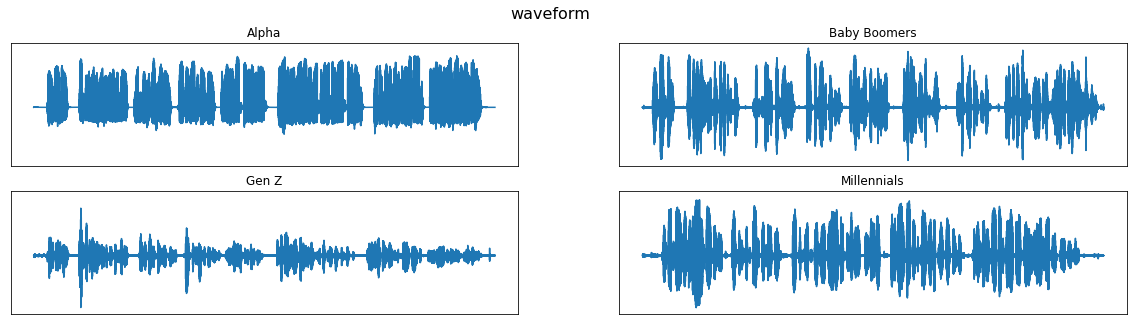

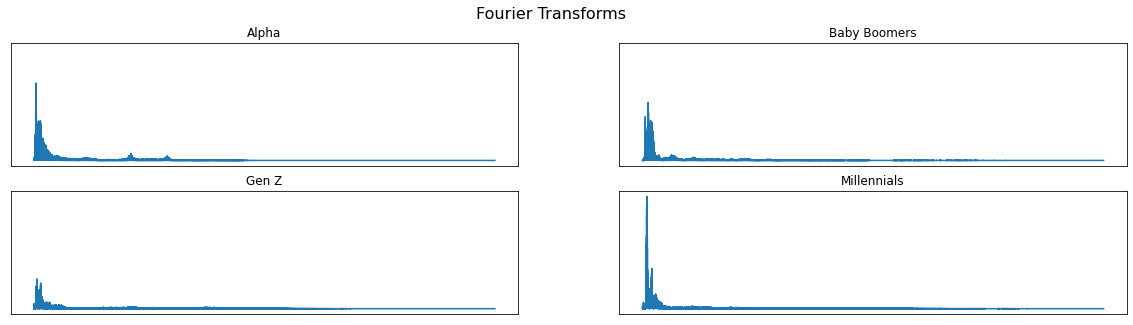

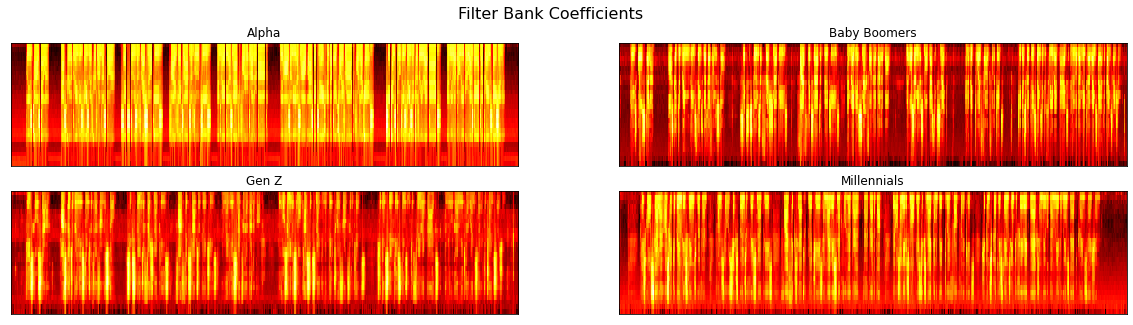

In [ ]:
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

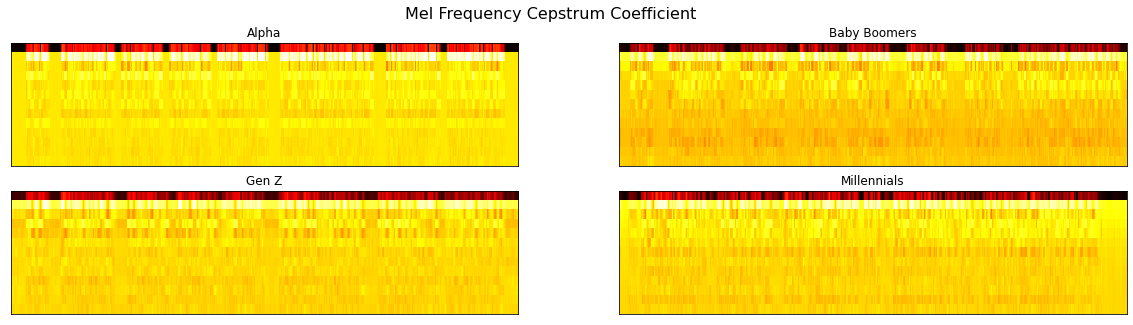

<Figure size 1080x720 with 0 Axes>

In [ ]:
plot_mfccs(mfccs)
plt.figure(figsize= FIG_SIZE)
plt.show()

Defining a function for signal enveloping

In [ ]:
def envelop(y, rate, threshold):
  mask = []
  y = pd.Series(y).apply(np.abs)
  y_mean = y.rolling(window=int(rate/10), min_periods=1, center = True).mean()
  for mean in y_mean:
    if mean > threshold:
            mask.append(True)
    else:
      mask.append(False)
  return mask

Plotting graph based after masking audio

In [ ]:
for c in classes:
  wav_file = new_df[new_df.age_group == c].iloc[0:1]
  filenames = wav_file["filename"].iloc[0]
  path = os.path.join("/Research/My Drive/Research/wavrecordings",filenames+".wav")
  signal, rate = librosa.load(path, sr=44100)
  mask = envelop(signal, rate, 0.0005)
  signal = signal[mask]
  signals[c] = signal
  fft[c] = calc_fft(signal, rate)
  bank = logfbank(signal, rate, nfilt=26, nfft = 2048).T
  fbank[c] = bank
  mel = mfcc(signal, rate, numcep=13, nfilt=26, nfft=2048).T
  mfccs[c] = mel

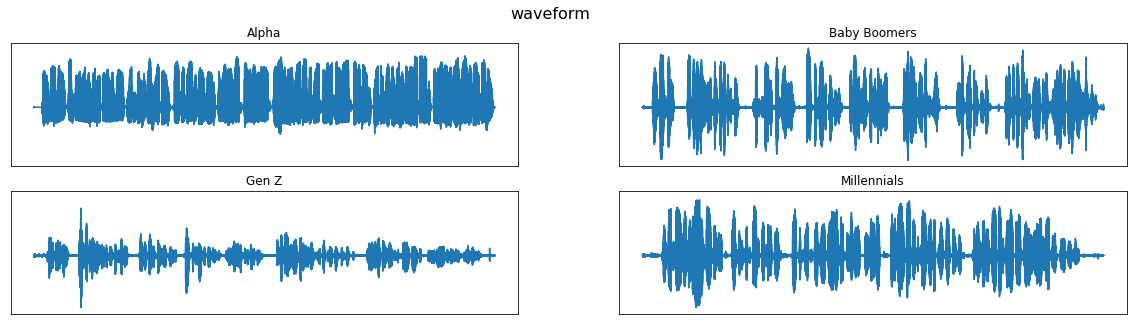

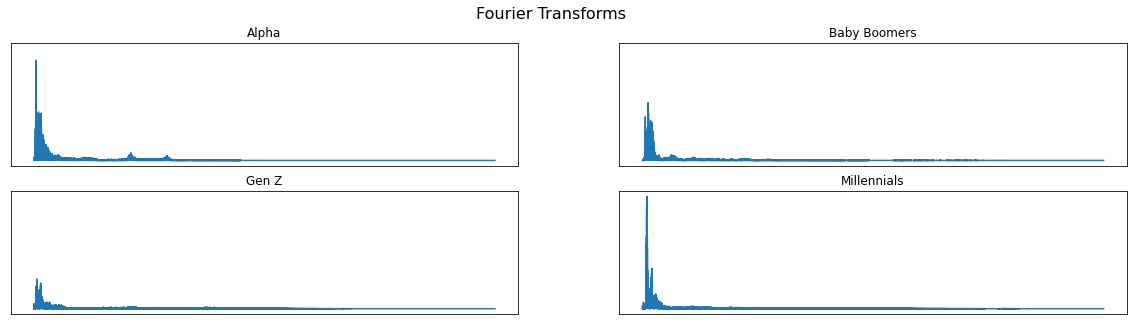

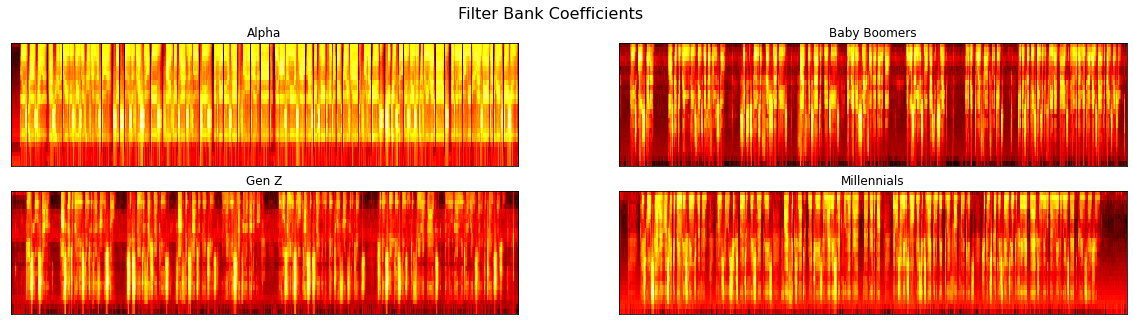

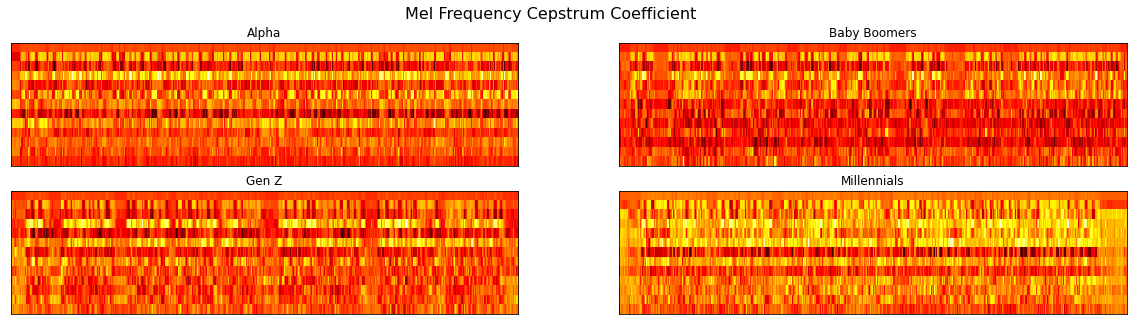

In [ ]:
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [ ]:
# files = glob('/Research/My Drive/Research/recordings/Clean/*')
# for f in files:
#   os.remove(f)

In [ ]:
# if len(os.listdir('/Research/My Drive/Research/recordings/Clean')) == 0:
#   for f in tqdm(new_df.filename):
#     path = os.path.join("/Research/My Drive/Research/wavrecordings/",f+".wav")
#     signal, rate = librosa.load(path, sr=16000)
#     mask = envelop(signal, rate, 0.0005)
#     wavfile.write(filename='/Research/My Drive/Research/recordings/Clean/'+f+".wav", rate=rate, data=signal[mask])
      

In [ ]:
# new_df.set_index('filename', inplace=True)
# for f in df.index:
#   path = os.path.join("/content/drive/My Drive/Research/wavrecordings/",f+".wav")
#   rate, signal = wavfile.read(path)
#   new_df.at[f, 'length'] = signal.shape[0]/rate

In [ ]:
# clean_dir = '/Research/My Drive/Research/recordings/Clean'

Finding length of clean audio files

In [ ]:
# def get_cleanaudio_len(row):
#   file_path = clean_dir + '/' + row.filename + '.wav'
#   return AudioSegment.from_file(file_path).duration_seconds

In [ ]:
# new_df['clean_len'] = new_df.apply(get_cleanaudio_len, axis=1)

In [ ]:
# new_df.head()

Saving as a csv file for future use

In [ ]:
# new_df.to_csv('/Research/My Drive/Research'+'/new_df.csv', sep=',', index=False, header=True)

In [ ]:
new_df = pd.read_csv('/Research/My Drive/Research/new_df.csv')

In [ ]:
new_df.head()

age  age_onset  ...     age_group  clean_len
0  27.0        9.0  ...   Millennials  20.772313
1  40.0        5.0  ...   Millennials  21.496500
2  43.0        4.0  ...  Baby Boomers  26.880000
3  26.0        8.0  ...   Millennials  23.020312
4  19.0        6.0  ...         Gen Z  20.252437

[5 rows x 12 columns]

Defining number of samples and our classes.

In [ ]:
n_samples = 2*int(new_df['clean_len'].sum())
classes = list(np.unique(new_df.age_group))
class_dist = new_df.groupby(['age_group'])['clean_len'].mean()
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

In [ ]:
new_df.set_index('filename', inplace=True)

In [ ]:
new_df.head()

age  age_onset  ...     age_group  clean_len
filename                     ...                         
afrikaans1  27.0        9.0  ...   Millennials  20.772313
afrikaans2  40.0        5.0  ...   Millennials  21.496500
afrikaans3  43.0        4.0  ...  Baby Boomers  26.880000
afrikaans4  26.0        8.0  ...   Millennials  23.020312
afrikaans5  19.0        6.0  ...         Gen Z  20.252437

[5 rows x 11 columns]

In [ ]:
# def check_data():
#   if os.path.isfile(pickles_path):
#     with open(pickles_path, 'rb') as handle:
#       tmp = pickle.load(handle)
#       return tmp
#   else:
#     return None

Creating our X and y feature for modelling

In [ ]:
def build_random_feat():
  # tmp = check_data()
  # if tmp:
  #   return tmp.data[0], tmp.data[1]
  X = []
  y = []
  _min, _max = float('inf'), -float('inf')
  for _ in tqdm(range(n_samples)):
    rand_class = np.random.choice(class_dist.index, p=prob_dist)
    file = np.random.choice(new_df[new_df.age_group==rand_class].index)
    path = os.path.join("/Research/My Drive/Research/recordings/Clean",file+".wav")
    rate, wav = wavfile.read(path)
    age_group = new_df.at[file, 'age_group']
    rand_index = np.random.randint(0, wav.shape[0]-int(rate))
    sample = wav[rand_index:rand_index+int(rate)]
    X_sample = mfcc(sample, rate, numcep=13, nfilt=26, nfft=512)
    _min = min(np.amin(X_sample), _min)
    _max = max(np.amax(X_sample), _max)
    X.append(X_sample)
    y.append(classes.index(age_group))
  X, y = np.array(X), np.array(y)
  X = (X- _min) / (_max - _min)
  X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
  y = to_categorical(y, num_classes=4)
  # data = (X, y)
  # with open(pickles_path, 'wb') as handle:
  #   pickle.dump(handle, protocol=pickle.HIGHEST_PROTOCOL)
  return X, y

In [ ]:
X, y = build_random_feat()

100%|██████████| 115916/115916 [28:18<00:00, 68.26it/s] 


In [ ]:
X.shape

(115916, 99, 13, 1)

In [ ]:
y.shape

(115916, 4)

Splitting dataset into train and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
X_train.shape

(92732, 99, 13, 1)

In [ ]:
y_train.shape

(92732, 4)

Defining shape of our input

In [ ]:
input_shape = (X.shape[1], X.shape[2], X.shape[3])

Creating our model

In [ ]:
model = Sequential()
model.add(Conv2D(256, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 13, 256)       2560      
_________________________________________________________________
activation (Activation)      (None, 99, 13, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 11, 128)       295040    
_________________________________________________________________
activation_1 (Activation)    (None, 97, 11, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 5, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 5, 64)         73792     
_________________________________________________________________
activation_2 (Activation)    (None, 48, 5, 64)         0

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=2, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.2, min_lr=1e-6, verbose=1)
 
callback_list = [es, rlrop]
# model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
# model.summary()

In [ ]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Fitting our model to the data

In [ ]:
result = model.fit(X_train,y_train,epochs=30,batch_size=32,validation_data=(X_test,y_test), callbacks=callback_list)

Epoch 1/30
2898/2898 [==============================] - 44s 15ms/step - loss: 0.9848 - accuracy: 0.4709 - val_loss: 0.8486 - val_accuracy: 0.5334
Epoch 2/30
2898/2898 [==============================] - 44s 15ms/step - loss: 0.8536 - accuracy: 0.5304 - val_loss: 0.8322 - val_accuracy: 0.5531
Epoch 3/30
2898/2898 [==============================] - 44s 15ms/step - loss: 0.8386 - accuracy: 0.5480 - val_loss: 0.8250 - val_accuracy: 0.5641
Epoch 4/30
2898/2898 [==============================] - 45s 15ms/step - loss: 0.8267 - accuracy: 0.5566 - val_loss: 0.8188 - val_accuracy: 0.5637
Epoch 5/30
2898/2898 [==============================] - 45s 15ms/step - loss: 0.8157 - accuracy: 0.5703 - val_loss: 0.8045 - val_accuracy: 0.5768
Epoch 6/30
2898/2898 [==============================] - 45s 16ms/step - loss: 0.8070 - accuracy: 0.5770 - val_loss: 0.8069 - val_accuracy: 0.5766
Epoch 7/30
2898/2898 [==============================] - 45s 16ms/step - loss: 0.7972 - accuracy: 0.5872 - val_loss: 0.7900 -

Plotting the results

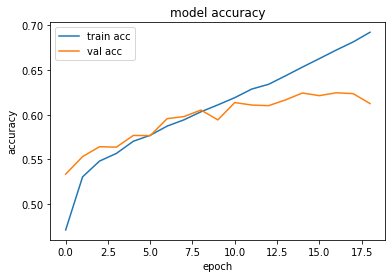

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(result.history['accuracy'], label='train acc')
plt.plot(result.history['val_accuracy'], label='val acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

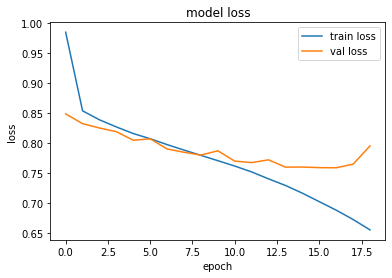

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('LossVal_loss')

Other evaluation techniques used

In [ ]:
yhat = np.argmax(model.predict(X_test), axis=-1)
yhat_classes = np.argmax(model.predict_classes(X_test), axis=-1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
y_test = np.argmax(y_test, axis=1)

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy of CNN: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat, pos_label='positive', average='micro')
print('Precision of CNN: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat, pos_label='positive', average='micro')
print('Recall of CNN: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat, pos_label='positive', average='micro')
print('F1 score of CNN: %f' % f1)

Accuracy of CNN: 0.624569
Precision of CNN: 0.624569
Recall of CNN: 0.624569
F1 score of CNN: 0.624569


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [ ]:
mean_absolute_error(y_test,yhat)

0.5147084195997239

Text(0.5, 15.0, 'Predicted label')

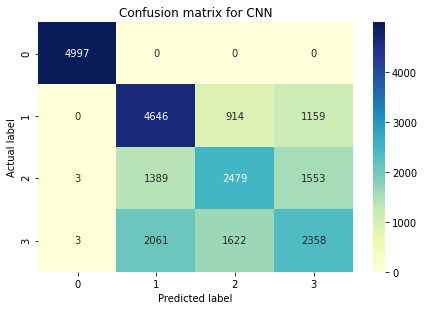

In [ ]:
cm = confusion_matrix(y_test, yhat)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
 
plt.tight_layout()
plt.title('Confusion matrix for CNN', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
model_path = os.path.join('Models')
pickles_path = os.path.join('pickles', '.p')

In [ ]:
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, period=1)

In [ ]:
model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Models/assets
